# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [67]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, \
                        mean_squared_error, r2_score, precision_recall_fscore_support 

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [68]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [69]:
default_seed = 1
output_file = "output_sample"

In [70]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [71]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [72]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = (data.loan_status == 'Default') | ((data.loan_status == 'Charged Off'))

In [73]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [74]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.rand(len(data)) < 0.70

In [75]:
data.train.sum()

610514

In [76]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [77]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
   
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [78]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count') 
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [79]:
## define your set of features to use in different models
# removed funded amount as correlated 
your_features = ['open_acc', 'revol_bal', 'revol_util', 'pub_rec', 'delinq_2yrs', 'dti', 'installment',
                 'fico_range_high', 'fico_range_low', 'annual_inc', 'int_rate', 'loan_amnt', 'funded_amnt', 
                 'cr_hist', 'emp_length',
                 'purpose', 'grade', 'term', 'home_ownership', 'verifications_status'
                ]
# prepare the train, test data for training models 
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [80]:
### List of only features related to loan application sans the LC derived features ###
just_your_features= list(set(your_features) - set([
'open_acc',
'revol_bal',
'revol_util',
'delinq_2yrs',
'dti',
'installment',
'int_rate',
'grade',
'verifications_status'
]))
just_your_features

['fico_range_low',
 'annual_inc',
 'home_ownership',
 'fico_range_high',
 'loan_amnt',
 'cr_hist',
 'purpose',
 'pub_rec',
 'term',
 'funded_amnt',
 'emp_length']

### Dummy Classifier

  Model: Dummy Model
Fit time: 0.16 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.8145
              precision    recall  f1-score   support

  No default     0.8145    1.0000    0.8978     16290
     Default     0.0000    0.0000    0.0000      3710

   micro avg     0.8145    0.8145    0.8145     20000
   macro avg     0.4073    0.5000    0.4489     20000
weighted avg     0.6634    0.8145    0.7312     20000



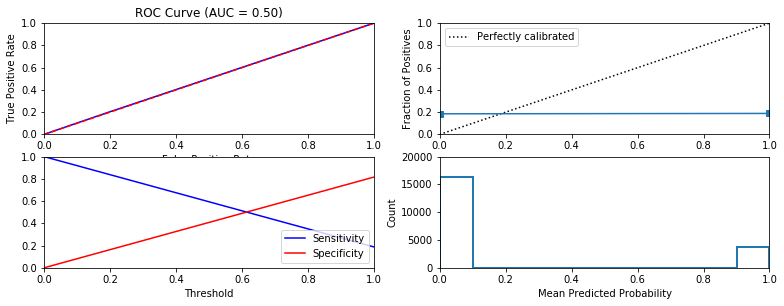


Similarity to LC grade ranking:  0.003814365153337725
Brier score: 0.30085
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.69413333]


In [47]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy='stratified', random_state=1234)
dummmy_clf = fit_classification(model=dummy_clf,
                               data_dict=data_dict,
                               cv_parameters={},
                               model_name = 'Dummy Model')

### Naive Bayes

  Model: Gaussian Naive Bayes
Fit time: 5.37 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.9999999999999716
Accuracy:  0.81577
              precision    recall  f1-score   support

  No default     0.8194    0.9926    0.8977     81429
     Default     0.5547    0.0404    0.0754     18571

   micro avg     0.8158    0.8158    0.8158    100000
   macro avg     0.6870    0.5165    0.4865    100000
weighted avg     0.7702    0.8158    0.7450    100000



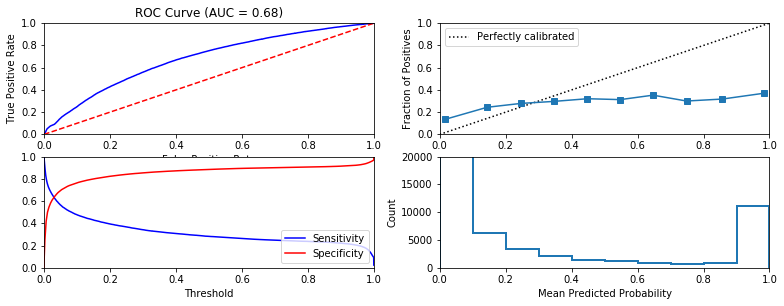


Similarity to LC grade ranking:  0.650284212113134
Brier score: 0.20114531143753303
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.69413333]


In [30]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(model = gnb, data_dict = data_dict,
                         cv_parameters = {},
                         model_name='Gaussian Naive Bayes',
                         output_to_file=True, 
                         print_to_screen= True
                        )

### $l_1$ regularized logistic regression

  Model: L1_LogisticRegression
Fit time: 944.42 seconds
Optimal parameters:
{'C': 0.1}

Accuracy-maximizing threshold was: 0.49163734512296825
Accuracy:  0.81756
              precision    recall  f1-score   support

  No default     0.8227    0.9891    0.8983     81429
     Default     0.5780    0.0652    0.1172     18571

   micro avg     0.8176    0.8176    0.8176    100000
   macro avg     0.7004    0.5272    0.5077    100000
weighted avg     0.7773    0.8176    0.7532    100000



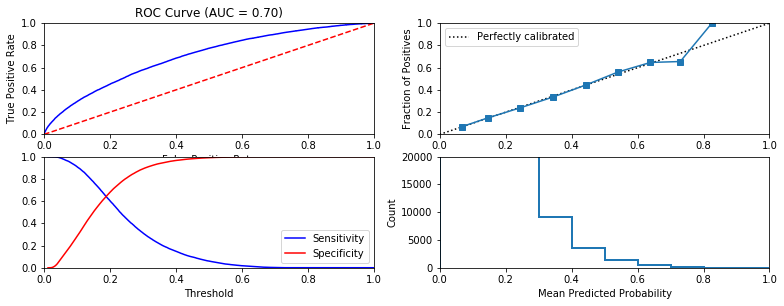


Similarity to LC grade ranking:  0.7395005748306253
Brier score: 0.13847667958577134
Were parameters on edge? : False
Score variations around CV search grid : 0.3539179987917059
[0.81651    0.816515   0.81651333 0.81657333 0.81473167 0.81368333]


In [32]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1', n_jobs=-1)
cv_parameters = {'C' : [100, 10, 1, .1, .001, .0001]}

l1_logistic = fit_classification(l1_logistic,data_dict,cv_parameters, 
                                 model_name='L1_LogisticRegression')

### $l_2$ regularized logistic regression

  Model: L2_Logistic_Regression
Fit time: 2.11 seconds
Optimal parameters:
{'C': 1}

Accuracy-maximizing threshold was: 0.48728799727986577
Accuracy:  0.81575
              precision    recall  f1-score   support

  No default     0.8218    0.9881    0.8973     16290
     Default     0.5303    0.0590    0.1062      3710

   micro avg     0.8157    0.8157    0.8157     20000
   macro avg     0.6760    0.5236    0.5018     20000
weighted avg     0.7677    0.8157    0.7505     20000



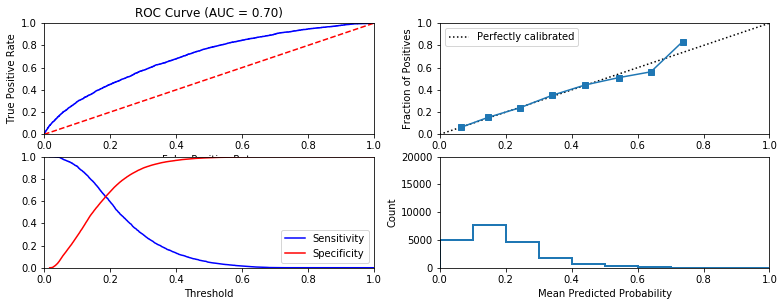


Similarity to LC grade ranking:  0.7507279785757206
Brier score: 0.13904409929702755
Were parameters on edge? : False
Score variations around CV search grid : 0.16343875132793548
[0.81543333 0.81553333 0.8158     0.81566667 0.81446667 0.81446667]


In [45]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2', n_jobs  = -1)
cv_parameters =  {'C' : [100, 10, 1, .1, .001, .0001]}

l2_logistic = fit_classification(l2_logistic, data_dict,cv_parameters, 
                                 model_name='L2_Logistic_Regression')

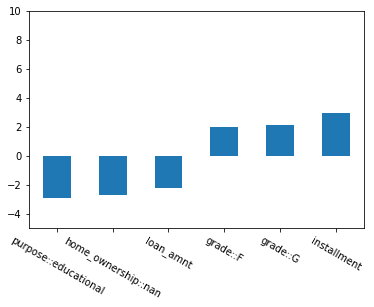

In [26]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision_Trees
Fit time: 129.01 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': None, 'min_samples_leaf': 10, 'min_samples_split': 2}

Accuracy-maximizing threshold was: 0.5454545454545454
Accuracy:  0.8163
              precision    recall  f1-score   support

  No default     0.8210    0.9904    0.8978     16290
     Default     0.5514    0.0520    0.0951      3710

   micro avg     0.8163    0.8163    0.8163     20000
   macro avg     0.6862    0.5212    0.4964     20000
weighted avg     0.7710    0.8163    0.7489     20000



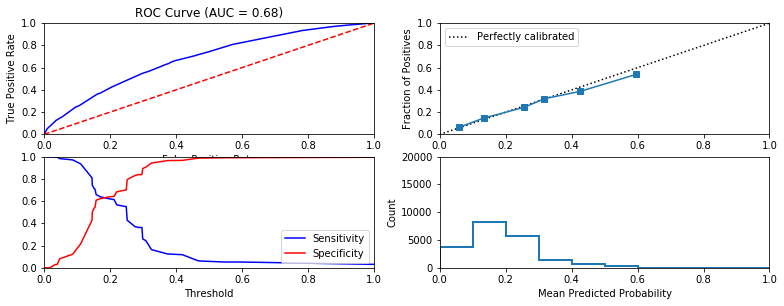


Similarity to LC grade ranking:  0.8007017395833516
Brier score: 0.1415690155575926
Were parameters on edge? : True
Score variations around CV search grid : 13.607944097094517
[0.7047     0.72256667 0.7363     0.73346667 0.73236667 0.74823333
 0.7612     0.76073333 0.76153333 0.81486667 0.81486667 0.81486667
 0.81486667 0.81486667 0.81486667 0.81486667 0.81486667 0.81486667
 0.8153     0.8153     0.8153     0.8153     0.8153     0.8153
 0.8153     0.8153     0.8153     0.8155     0.8155     0.8155
 0.8155     0.8155     0.8155     0.8155     0.8155     0.8155
 0.8151     0.8151     0.8151     0.8151     0.8151     0.8151
 0.8151     0.8151     0.8151     0.81486667 0.81486667 0.81486667
 0.81486667 0.81486667 0.81486667 0.81486667 0.81486667 0.81486667
 0.8152     0.8152     0.8152     0.8152     0.8152     0.8152
 0.8152     0.8152     0.8152     0.8152     0.8152     0.8152
 0.8152     0.8152     0.8152     0.8152     0.8152     0.8152
 0.81463333 0.81466667 0.81523333 0.81473333 0.

In [30]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters = {"criterion": ["gini", "entropy"],
                  "min_samples_split": [2, 10, 20],
                  "max_depth": [None, 2, 5, 10],
                  "min_samples_leaf": [1, 5, 10],
                  "max_leaf_nodes": [None, 5, 10, 20],
                }

decision_tree = fit_classification(decision_tree, data_dict, cv_parameters, 'Decision_Trees')

### Random forest

  Model: Random_Forest
Fit time: 1747.26 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}

Accuracy-maximizing threshold was: 0.31026587689119384
Accuracy:  0.78845
              precision    recall  f1-score   support

  No default     0.8469    0.9036    0.8743     16290
     Default     0.4006    0.2830    0.3317      3710

   micro avg     0.7884    0.7884    0.7884     20000
   macro avg     0.6238    0.5933    0.6030     20000
weighted avg     0.7641    0.7884    0.7737     20000



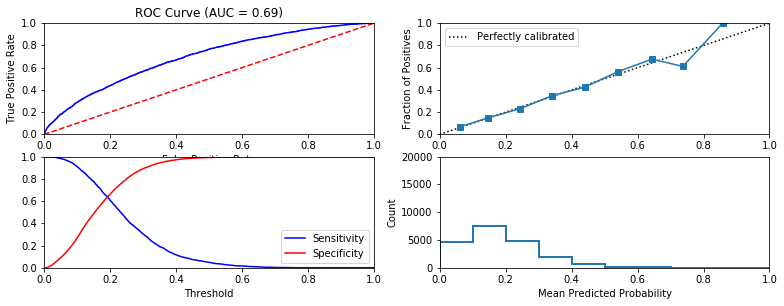


Similarity to LC grade ranking:  0.585691604699121
Brier score: 0.13941826393690593
Were parameters on edge? : True
Score variations around CV search grid : 0.3426333822809624
[0.81466667 0.81463333 0.8148     0.81466667 0.81466667 0.81483333
 0.81446667 0.81446667 0.81446667 0.81686667 0.81653333 0.81643333
 0.8168     0.81703333 0.8168     0.81643333 0.8162     0.81633333
 0.81616667 0.8162     0.81646667 0.81546667 0.8161     0.81696667
 0.81663333 0.81673333 0.81696667 0.81593333 0.81583333 0.8159
 0.81473333 0.81593333 0.81606667 0.81526667 0.81616667 0.8167
 0.8144     0.81463333 0.81466667 0.81453333 0.81446667 0.8146
 0.81446667 0.81446667 0.81446667 0.8167     0.817      0.81663333
 0.81663333 0.81686667 0.8168     0.81633333 0.81596667 0.81613333
 0.81596667 0.81623333 0.8172     0.81606667 0.8165     0.81693333
 0.8165     0.8162     0.81713333 0.8145     0.8165     0.81596667
 0.8154     0.81543333 0.81606667 0.8166     0.81546667 0.8165    ]


In [26]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters =  { 'n_estimators': [100, 200, 500],
                    'max_features': ['auto', 'sqrt', 'log2'],
                    'max_depth' : [5, 10, 20, None],
                    'criterion' :['gini', 'entropy']
                }

random_forest = fit_classification(random_forest, data_dict, cv_parameters, 'Random_Forest')

  Model: Random_Forest
Fit time: 53.31 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 200}

Accuracy-maximizing threshold was: 0.3407366880327241
Accuracy:  0.80825
              precision    recall  f1-score   support

  No default     0.8348    0.9532    0.8901     16290
     Default     0.4553    0.1717    0.2494      3710

   micro avg     0.8083    0.8083    0.8083     20000
   macro avg     0.6451    0.5625    0.5697     20000
weighted avg     0.7644    0.8083    0.7712     20000



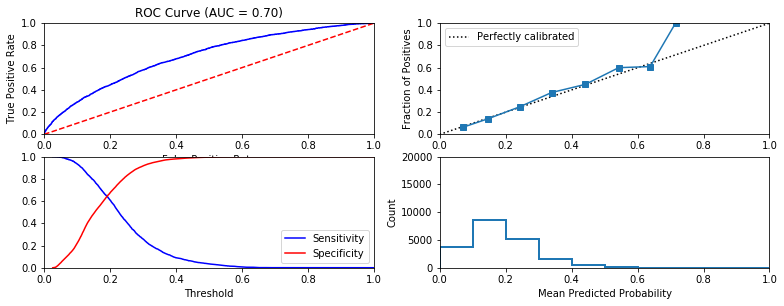


Similarity to LC grade ranking:  0.7356193205542497
Brier score: 0.1390275040397614
Were parameters on edge? : True
Score variations around CV search grid : 0.3060100371292113
[0.81446667 0.81446667 0.81446667 0.8145     0.81463333 0.8146
 0.81633333 0.8163     0.81696667]


In [178]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier()
cv_parameters =  { 'n_estimators': [100, 150, 200],
                    'max_depth' : [2, 5, 10],
                    'criterion' :['gini']
                }

random_forest = fit_classification(random_forest, data_dict, cv_parameters, 'Random_Forest')

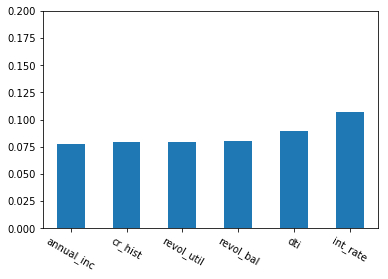

In [35]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: MLP_Classifier
Fit time: 1137.0 seconds
Optimal parameters:
{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'}

Accuracy-maximizing threshold was: 0.5069446482953933
Accuracy:  0.81515
              precision    recall  f1-score   support

  No default     0.8197    0.9910    0.8973     16290
     Default     0.5212    0.0431    0.0797      3710

   micro avg     0.8152    0.8152    0.8151     20000
   macro avg     0.6705    0.5171    0.4885     20000
weighted avg     0.7643    0.8152    0.7456     20000



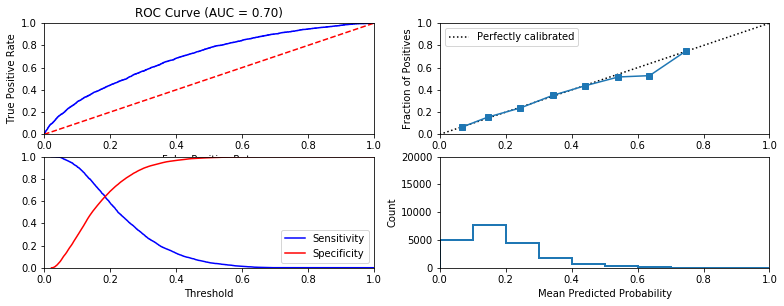


Similarity to LC grade ranking:  0.7340648484614586
Brier score: 0.13933691992772457
Were parameters on edge? : True
Score variations around CV search grid : 0.15119937885660273
[0.81516667 0.8151     0.81536667 0.81523333 0.8152     0.8151
 0.81536667 0.81523333 0.81493333 0.81503333 0.81526667 0.8157
 0.81446667 0.81446667 0.81483333 0.8147     0.81446667 0.81446667
 0.8148     0.81466667 0.81446667 0.81446667 0.81516667 0.81503333
 0.81446667 0.81446667 0.81446667 0.81446667 0.81446667 0.81446667
 0.81446667 0.81446667 0.81446667 0.81446667 0.81446667 0.81446667]


In [46]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier(random_state=0)
cv_parameters = {'hidden_layer_sizes': [(20,2), (100,50,50)],
                 'activation': ['tanh', 'relu', 'logistic'],
                 'solver': ['sgd'],
                 'alpha': [0.0001,0.001, 0.05],
                 'learning_rate': ['constant','adaptive'],
                }

mlp = fit_classification(mlp, data_dict ,cv_parameters, 'MLP_Classifier')

## Train and Test logistic regression model with features derived by LendingClub

  Model: L1_LogisticRegression
Fit time: 0.77 seconds
Optimal parameters:
{'C': 100}

Accuracy-maximizing threshold was: 0.4801884583799039
Accuracy:  0.8162
              precision    recall  f1-score   support

  No default     0.8205    0.9911    0.8978     16290
     Default     0.5525    0.0482    0.0887      3710

   micro avg     0.8162    0.8162    0.8162     20000
   macro avg     0.6865    0.5197    0.4933     20000
weighted avg     0.7708    0.8162    0.7477     20000



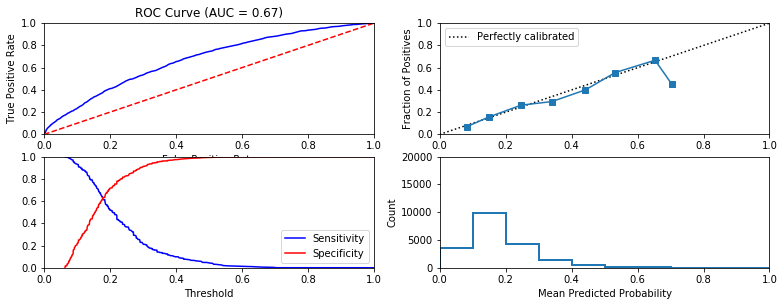


Similarity to LC grade ranking:  0.855808688051289
Brier score: 0.14218147948364815
Were parameters on edge? : True
Score variations around CV search grid : 0.11037978823433366
[0.81536667 0.81536667 0.81523333 0.81493333 0.81446667 0.81446667]


In [117]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['int_rate']

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1')

cv_parameters = {'C' : [100, 10, 1, .1, .001, .0001]}

lc1_only_logistic = fit_classification(lc1_only_logistic,data_dict,cv_parameters, model_name='L1_LogisticRegression')

  Model: L2_Logistic_Regression
Fit time: 0.42 seconds
Optimal parameters:
{'C': 100}

Accuracy-maximizing threshold was: 0.480191142299463
Accuracy:  0.8162
              precision    recall  f1-score   support

  No default     0.8205    0.9911    0.8978     16290
     Default     0.5525    0.0482    0.0887      3710

   micro avg     0.8162    0.8162    0.8162     20000
   macro avg     0.6865    0.5197    0.4933     20000
weighted avg     0.7708    0.8162    0.7477     20000



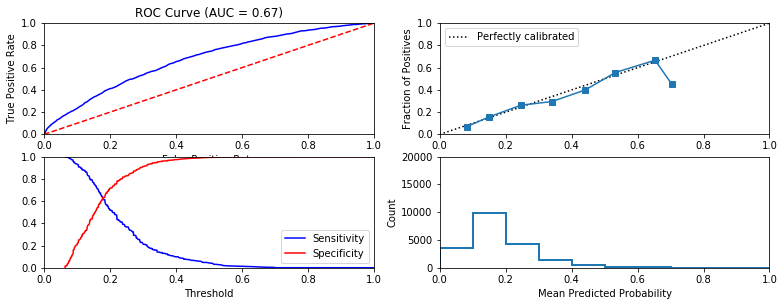


Similarity to LC grade ranking:  0.855808688051289
Brier score: 0.14218151078866684
Were parameters on edge? : True
Score variations around CV search grid : 0.11037978823433366
[0.81536667 0.81536667 0.8152     0.81473333 0.81446667 0.81446667]


In [118]:
.## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2')

lc2_only_logistic = fit_classification(lc2_only_logistic, data_dict,cv_parameters, 
                                 model_name='L2_Logistic_Regression')


## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [36]:
# Using only our features
# print(just_your_features)
data_dict_100=[prepare_data(feature_subset = just_your_features, random_state=np.random.randint(1000)) for i in range(100)]
# print(data_dict_100)

prepare_data(feature_subset = just_your_features, random_state=np.random.randint(1000))['X_train'].shape

cols=data_dict_100[0]['cols']

##### Fit classification method for 100 datasets 

In [35]:
def fit_classification_100(model, data_dict_100,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    cv_model_li=[]
    start_time_li=[]
    end_time_li=[]
    best_model_li=[]
    best_threshold_li=[]
    accuracy_scores_li=[]
    f1_scores_li=[]
    precision_li=[]
    recall_li=[]
    y_pred_li=[]
    for i in range(100): 
        print(i,end=' ')
        np.random.seed(random_state)
    
        # --------------------------
        #   Step 1 - Load the data
        # --------------------------
        X_train = data_dict_100[i]['X_train']
        y_train = data_dict_100[i]['y_train']
    
        X_test = data_dict_100[i]['X_test']
        y_test = data_dict_100[i]['y_test']
    
        filter_train = data_dict_100[i]['train_set']    
  
        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        cv_model = GridSearchCV(model, cv_parameters)
    
        start_time = time.time()
        cv_model.fit(X_train, y_train)
        cv_model_li.append(cv_model)
        end_time = time.time()
    
        start_time_li.append(start_time)
        end_time_li.append(end_time)
        
        best_model = cv_model.best_estimator_
        best_model_li.append(best_model)
        
        # -------------------------------
        #   Step 3 - Evaluate the model
        # -------------------------------
    
        # If possible, make probability predictions
        try:
            y_pred_probs = best_model.predict_proba(X_test)[:,1]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
            probs_predicted = True
        except:
            probs_predicted = False
    
        # Make predictions; if we were able to find probabilities, use
        # the threshold that maximizes the accuracy in the training set.
        # If not, just use the learner's predict function
        if probs_predicted:
            y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
            fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
            true_pos_train = tpr_train*(y_train.sum())
            true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
            best_threshold_index = np.argmax(true_pos_train + true_neg_train)
            best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
            best_threshold_li.append(best_threshold)
            
            y_pred = (y_pred_probs > best_threshold)
        else:
            y_pred = best_model.predict(X_test)
    
        y_pred_li.append(y_pred)
        
        # Calculate the accuracy score for the best model and append it to the list of 100 different train test splits
        accuracy_scores_li.append(accuracy_score(y_test, y_pred))
        precision, recall, f1, *_ = precision_recall_fscore_support(y_test, y_pred)
        f1_scores_li.append(f1)
        precision_li.append(precision)
        recall_li.append(recall)
        #roc_auc_score_li.append(roc_auc_score(y_test,y_pred))
     
    # Picking the model with the best F1 score for 
    best_model_index=np.argmax(f1_scores_li)
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(np.amax(end_time_li) - np.amin(start_time_li), 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model_li[best_model_index].best_params_)
        print("")

        print("Accuracy-maximizing threshold was: " + str(best_threshold_li[best_model_index]))
        
        y_train_pred_probs = best_model_li[best_model_index].predict_proba(data_dict_100[best_model_index]['X_train'])[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(data_dict_100[best_model_index]['y_train'], y_train_pred_probs)
        
        print("Accuracy: ","(" , np.mean(accuracy_scores_li) , ", +-" , np.std(accuracy_scores_li) , ")")
        print("F1-Score: ","(" , np.mean(f1_scores_li) , ", +-" , np.std(f1_scores_li) , ")")
        print("Precision: ","(" , np.mean(precision_li) , ", +-" , np.std(precision_li) , ")")
        print("Recall: ","(" , np.mean(recall_li) , ", +-" , np.std(recall_li) , ")")
        
        print("\nThe model below represents the model with the best f1-score of the 100 different test-train splits")
        print(classification_report(data_dict_100[best_model_index]['y_test'], y_pred_li[best_model_index], target_names =['No default', 'Default'], digits = 4))

        y_pred_probs = best_model_li[best_model_index].predict_proba(data_dict_100[best_model_index]['X_test'])[:,1]
        fpr, tpr, thresholds = roc_curve(data_dict_100[best_model_index]['y_test'], y_pred_probs)
        
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(data_dict_100[best_model_index]['y_test'], y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(data_dict_100[best_model_index]['y_test'], y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model_li[best_model_index].decision_function(data_dict_100[best_model_index]['X_train'])
        
    tau, p_value = kendalltau(y_train_score, data.grade[data_dict_100[best_model_index]['train_set']])
    print("")
    print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(data_dict_100[best_model_index]['y_test'], y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model_li[best_model_index], 'y_pred_labels':y_pred_li[best_model_index]}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(data_dict_100[best_model_index]['X_test'])
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model_li[best_model_index])
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model_li[best_model_index])
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model_li[best_model_index].cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model_li[best_model_index].cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(data_dict_100[best_model_index]['y_test'], y_pred_probs) )
        
    return out

### Naive Bayes

  Model: Gaussian Naive Bayes
Fit time: 13.48 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  ( 0.8155100000000002 , +- 0.002692090265945778 )
F1-Score:  ( 0.4494065108473626 , +- 0.4489703429820788 )
Precision:  ( 0.41804753474790407 , +- 0.40091182326487035 )
Recall:  ( 0.5000342212333908 , +- 0.49981251524860854 )

The model below represents the model with the best f1-score of the 100 different test-train splits
              precision    recall  f1-score   support

  No default     0.8134    1.0000    0.8971     16267
     Default     0.0000    0.0000    0.0000      3733

   micro avg     0.8134    0.8134    0.8134     20000
   macro avg     0.4067    0.5000    0.4485     20000
weighted avg     0.6615    0.8134    0.7296     20000



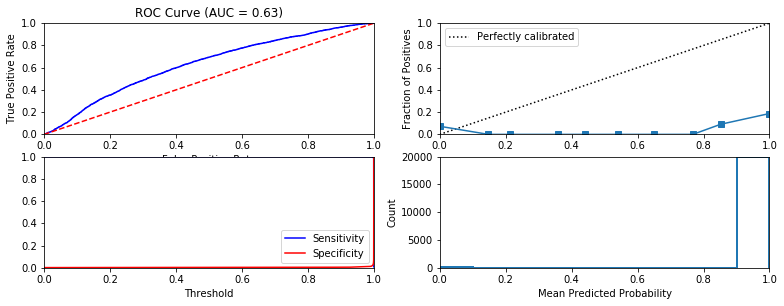


Similarity to LC grade ranking:  0.32588550558653384
Brier score: 0.8094778382078154
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.19933333]


In [31]:
## Train and test a naive bayes classifier

gnb100 = GaussianNB()

gnb100 = fit_classification_100(gnb100, data_dict_100, model_name='Gaussian Naive Bayes',
                         #random_state = 1234, 
                         output_to_file=True, 
                         print_to_screen= True
                        )

### L1 Logistic Regression

  Model: L1_LogisticRegression
Fit time: 1210.46 seconds
Optimal parameters:
{'C': 100}

Accuracy-maximizing threshold was: 0.45295001531316215
Accuracy:  ( 0.8157785000000001 , +- 0.0027730331317890825 )
F1-Score:  ( 0.4705690691611627 , +- 0.42794483153377977 )
Precision:  ( 0.6397136146128113 , +- 0.21722708530790952 )
Recall:  ( 0.5089873927169037 , +- 0.48618347894870895 )

The model below represents the model with the best f1-score of the 100 different test-train splits
              precision    recall  f1-score   support

  No default     0.8214    0.9901    0.8979     16321
     Default     0.5076    0.0451    0.0829      3679

   micro avg     0.8163    0.8163    0.8163     20000
   macro avg     0.6645    0.5176    0.4904     20000
weighted avg     0.7637    0.8163    0.7480     20000



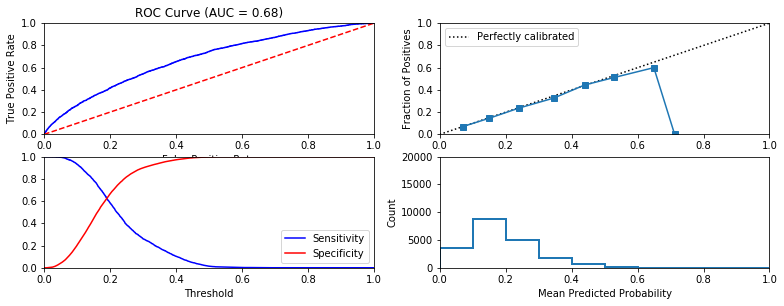


Similarity to LC grade ranking:  0.4687449469163275
Brier score: 0.1408158058628641
Were parameters on edge? : True
Score variations around CV search grid : 0.102694709168586
[0.81146667 0.81146667 0.81126667 0.81063333 0.81093333 0.81093333]


In [32]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic100 = LogisticRegression(penalty='l1')
cv_parameters = {'C' : [100, 10, 1, .1, .001, .0001]}

l1_logistic100 = fit_classification_100(l1_logistic100,data_dict_100,cv_parameters, 
                                 model_name='L1_LogisticRegression')

### L2 Logistic Regression


  Model: L2_Logistic_Regression
Fit time: 136.67 seconds
Optimal parameters:
{'C': 100}

Accuracy-maximizing threshold was: 0.4641900050216154
Accuracy:  ( 0.8157809999999999 , +- 0.00280895692384201 )
F1-Score:  ( 0.47027192497789455 , +- 0.4282547253758094 )
Precision:  ( 0.6541342104395557 , +- 0.193384119901151 )
Recall:  ( 0.5088579125382096 , +- 0.4863800789132937 )

The model below represents the model with the best f1-score of the 100 different test-train splits
              precision    recall  f1-score   support

  No default     0.8176    0.9947    0.8975     16267
     Default     0.5905    0.0332    0.0629      3733

   micro avg     0.8153    0.8153    0.8153     20000
   macro avg     0.7041    0.5140    0.4802     20000
weighted avg     0.7752    0.8153    0.7417     20000



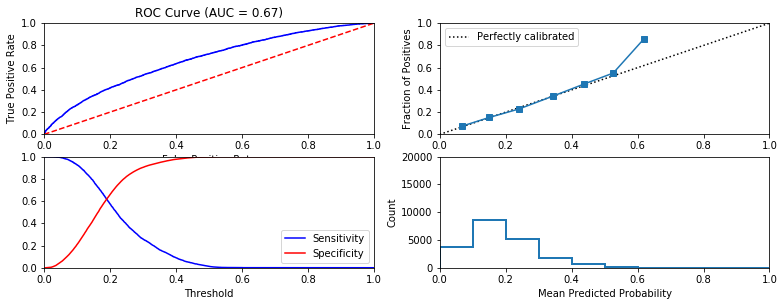


Similarity to LC grade ranking:  0.4671256353550969
Brier score: 0.14263143487812455
Were parameters on edge? : True
Score variations around CV search grid : 0.06960936860208605
[0.81406667 0.81403333 0.81393333 0.8135     0.81373333 0.81373333]


In [33]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic100 = LogisticRegression(penalty='l2')
cv_parameters =  {'C' : [100, 10, 1, .1, .001, .0001]}

l2_logistic100 = fit_classification_100(l2_logistic100, data_dict_100,cv_parameters, 
                                 model_name='L2_Logistic_Regression')

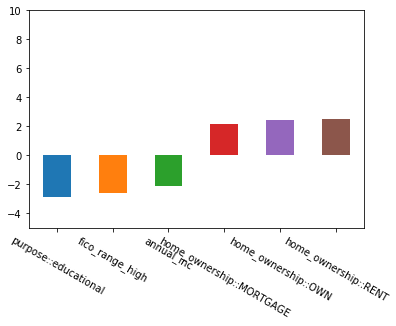

In [66]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic100['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic100['model'].coef_)[0,-3:])

bplot = pd.Series(l2_logistic100['model'].coef_[0,top_and_bottom_idx])

#############
all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in just_your_features]
your_selected_features = all_features[idx]
your_selected_features.reset_index(drop=True,inplace=True)
#############

xticks = your_selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision Tree

  Model: Decision_Trees
Fit time: 4956.04 seconds
Optimal parameters:
{'criterion': 'gini', 'max_depth': None, 'max_leaf_nodes': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}

Accuracy-maximizing threshold was: 1
Accuracy:  ( 0.8156530000000002 , +- 0.0028368364422363145 )
F1-Score:  ( 0.44923262210243 , +- 0.44923427157510315 )
Precision:  ( 0.4078265 , +- 0.4078314332205771 )
Recall:  ( 0.5 , +- 0.5 )

The model below represents the model with the best f1-score of the 100 different test-train splits
              precision    recall  f1-score   support

  No default     0.8112    1.0000    0.8958     16224
     Default     0.0000    0.0000    0.0000      3776

   micro avg     0.8112    0.8112    0.8112     20000
   macro avg     0.4056    0.5000    0.4479     20000
weighted avg     0.6580    0.8112    0.7266     20000



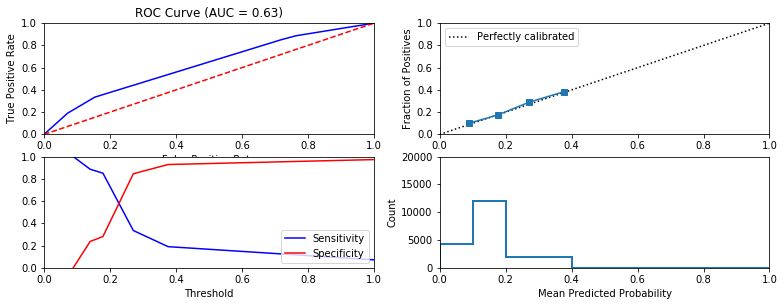


Similarity to LC grade ranking:  0.45859918118167303
Brier score: 0.14692312214345865
Were parameters on edge? : True
Score variations around CV search grid : 13.15714227359994
[0.70866667 0.73593333 0.75413333 0.74656667 0.74606667 0.76586667
 0.7782     0.77816667 0.7787     0.81603333 0.81603333 0.81603333
 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333
 0.81586667 0.81586667 0.81586667 0.81586667 0.81586667 0.81586667
 0.81586667 0.81586667 0.81586667 0.81466667 0.81466667 0.81466667
 0.81466667 0.81466667 0.81466667 0.81466667 0.81466667 0.81466667
 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333
 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333
 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333
 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333
 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333
 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333 0.81603333
 0.81463333 0.8146

In [67]:
## Train and test a decision tree classifier

decision_tree100 = DecisionTreeClassifier()
cv_parameters = {"criterion": ["gini", "entropy"],
                  "min_samples_split": [2, 10, 20],
                  "max_depth": [None, 2, 5, 10],
                  "min_samples_leaf": [1, 5, 10],
                  "max_leaf_nodes": [None, 5, 10, 20],
                }

decision_tree100 = fit_classification_100(decision_tree100, data_dict_100, cv_parameters, 'Decision_Trees')

### Random Forest

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 =========================================================
  Model: Random_Forest
Fit time: 3370.44 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 300}

Accuracy-maximizing threshold was: 0.34251144010552764
Accuracy:  ( 0.806122 , +- 0.005565089037922034 )
F1-Score:  ( 0.5393311942046383 , +- 0.35127936484465955 )
Precision:  ( 0.6240817477099069 , +- 0.20623993975666063 )
Recall:  ( 0.5421200910590445 , +- 0.41833825272714514 )

The model below represents the model with the best f1-score of the 100 different test-train splits
              precision    recall  f1-score   support

  No default     0.8178    0.9921    0.8966     16277
     D

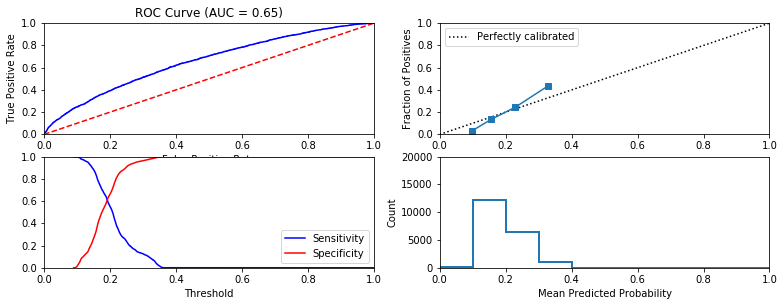


Similarity to LC grade ranking:  0.4294978449700512
Brier score: 0.14493439510941197
Were parameters on edge? : True
Score variations around CV search grid : 0.020535567603086287
[0.8116     0.81143333]


In [38]:
## Train and test a random forest classifier

random_forest_100 = RandomForestClassifier(n_jobs=-1)
cv_parameters =  { 'n_estimators': [50, 150, 300],
                    'max_features': ['auto'],
                    'max_depth' : [5, 10],
                    'criterion' :['entropy']
                }

random_forest_100 = fit_classification_100(random_forest_100, data_dict_100, cv_parameters, 'Random_Forest')

[32, 0, 4, 1, 3, 5]
['loan_amnt', 'pub_rec', 'annual_inc', 'fico_range_high', 'cr_hist', 'emp_length', 'term', 'home_ownership', 'purpose']


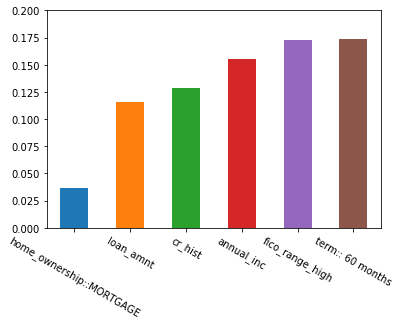

In [27]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest_100['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest_100['model'].feature_importances_[top_idx])
print(top_idx)
print(just_your_features)
xticks = your_selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi layer Perceptron

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
  Model: MLP_Classifier
Fit time: 2310.2 seconds
Optimal parameters:
{'activation': 'relu', 'hidden_layer_sizes': (20,), 'solver': 'sgd'}

Accuracy-maximizing threshold was: 0.4498028764056993
Accuracy:  ( 0.8100433333333333 , +- 0.0020822157002151026 )
F1-Score:  ( 0.46186187504526083 , +- 0.4329686175357861 )
Precision:  ( 0.6473436484664933 , +- 0.1695724595785078 )
Recall:  ( 0.5056374181518133 , +- 0.4906059862464017 )

The model below represents the model with the best f1-score of the 100 different test-train splits
             precision    recall  f1-score   support

 No default     0.8138    0.9974    0.8963     16253
    Default     0.4815    0.0104    0.0204      3747

avg / total     0.7516    0.8125    0.7322     20000



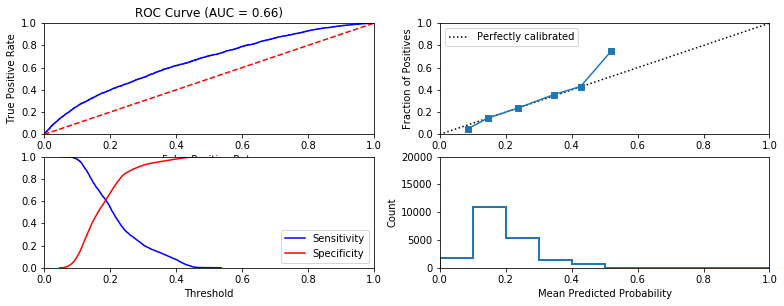


Similarity to LC grade ranking:  0.40993150531651107
Brier score: 0.14455640230079966
Were parameters on edge? : True
Score variations around CV search grid : 0.004105258836569194
[0.81196667 0.81193333 0.81196667 0.81196667 0.81196667 0.81196667]


In [20]:
## Train and test a multi-layer perceptron classifier
mlp_100 = MLPClassifier()
cv_parameters = {'hidden_layer_sizes': [(20,),(20,40,20),(100,)],
                 'activation': ['relu','logistic'], #  'tanh'
                 'solver': ['sgd','adam'],
                 'alpha': [0.0001],
                 'learning_rate': ['constant'], #'adaptive'
                }

mlp_100 = fit_classification_100(mlp_100, data_dict_100 ,cv_parameters, 'MLP_Classifier')

# BEST MODEL -RANDOM FOREST

In [158]:
YourModel = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
              max_depth=5, max_features='auto',
              min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
              oob_score=False, random_state=None, verbose=0,
              warm_start=False)

In [53]:
import _pickle as cPickle
with open('your_model', 'wb') as f:
    cPickle.dump(YourModel, f)

In [214]:
with open('new_best_model', 'rb') as f:
    random_forest_100 = cPickle.load(f)

## Time stability test of YOURMODEL

  Model: Random Forest
Fit time: 3.16 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}

Accuracy-maximizing threshold was: 0.38421406052534623
Accuracy:  0.881
              precision    recall  f1-score   support

  No default     0.8849    0.9948    0.9367      6191
     Default     0.2000    0.0099    0.0188       809

   micro avg     0.8810    0.8810    0.8810      7000
   macro avg     0.5425    0.5024    0.4778      7000
weighted avg     0.8058    0.8810    0.8306      7000



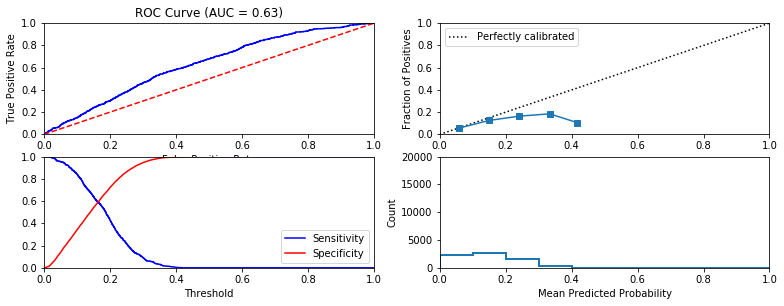


Similarity to LC grade ranking:  0.5361561853072747
Brier score: 0.10363685069756899


{'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=10, max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.18058242, 0.03077598, 0.23800472, ..., 0.27528445, 0.19456766,
        0.12267451])}

In [40]:
random_forest_100['model']## Define the time window of your train and test data -- Year 2010  VS 2017
start_date_train = datetime.date(2010, 1, 1)
end_date_train = datetime.date(2010, 12, 31)
start_date_test = datetime.date(2017, 1, 1)
end_date_test = datetime.date(2017, 12, 1)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

# Train and test YOURMODEL using this data
cv_parameters = {'criterion': ['entropy'], 'max_depth': [10], 'max_features': ['sqrt'], 'n_estimators': [500]}
fit_classification(random_forest_100['model'], data_dict_test,cv_parameters,model_name='Random Forest', 
                   random_state=2, output_to_file=False)

  Model: Random Forest
Fit time: 4.28 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 500}

Accuracy-maximizing threshold was: 0.33293307640847475
Accuracy:  0.8145714285714286
              precision    recall  f1-score   support

  No default     0.9080    0.8785    0.8930      6167
     Default     0.2749    0.3409    0.3044       833

   micro avg     0.8146    0.8146    0.8146      7000
   macro avg     0.5915    0.6097    0.5987      7000
weighted avg     0.8327    0.8146    0.8230      7000



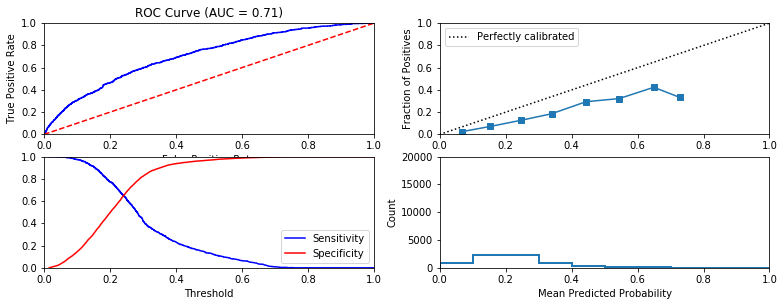


Similarity to LC grade ranking:  0.6785977767271467
Brier score: 0.11143595361162012


{'model': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
             max_depth=10, max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'y_pred_labels': array([False, False, False, ..., False,  True, False]),
 'y_pred_probs': array([0.13068788, 0.07919814, 0.13886823, ..., 0.31996244, 0.36860343,
        0.28099177])}

In [41]:
## Define the time window of your train and test data -- Year 2016 VS 2017
start_date_train = datetime.date(2016, 1, 1)
end_date_train = datetime.date(2016, 12, 31)
start_date_test = datetime.date(2017, 1, 1)
end_date_test = datetime.date(2017, 12, 1)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

# Train and test YOURMODEL using this data
cv_parameters = {'criterion': ['entropy'], 'max_depth': [10], 'max_features': ['sqrt'], 'n_estimators': [500]}
fit_classification(random_forest_100['model'], data_dict_test,cv_parameters,model_name='Random Forest',
                   random_state=2, output_to_file=False)

## Train and test YOURMODEL on the original data

In [61]:
# Read the data and features from the pickle file saved in CS-Phase 2
original_data, discrete_features, continuous_features = pickle.load(open("raw_data.pickle", "rb" ))

In [226]:
import _pickle as cPickle
with open('your_model', 'rb') as f:
    rf = cPickle.load(f)

In [63]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
original_data["outcome"] = (original_data.loan_status == 'Default') | ((original_data.loan_status == 'Charged Off'))

In [66]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
original_data['train'] = np.random.rand(len(original_data)) < 0.70

In [67]:
original_data.isna().sum()>0

id                     False
loan_amnt              False
funded_amnt            False
term                   False
int_rate               False
installment            False
grade                  False
emp_length             False
home_ownership         False
annual_inc              True
verification_status    False
issue_d                False
loan_status            False
purpose                False
dti                     True
delinq_2yrs             True
earliest_cr_line        True
open_acc                True
pub_rec                 True
fico_range_high        False
fico_range_low         False
revol_bal              False
revol_util              True
total_pymnt            False
last_pymnt_d            True
recoveries             False
outcome                False
train                  False
dtype: bool

In [68]:
original_data.dropna(axis=0, how='any', thresh=None, 
                     subset=['annual_inc','dti','delinq_2yrs','earliest_cr_line',
                             'open_acc','pub_rec','revol_util','last_pymnt_d'], 
                     inplace=True)

In [69]:
original_data.train.sum()

1233227

In [70]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = original_data[continuous_features].values

X_discrete = pd.get_dummies(original_data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )
y = original_data.outcome.values

train = original_data.train.values

In [71]:
all_col = continuous_features + discrete_features_dummies
columns_to_remove = ['home_ownership::nan','purpose::nan',
                     'emp_length::nan','verification_status::nan',
                     'term::nan','grade::nan']
#Updating the discrete_features
for x in columns_to_remove:
    discrete_features_dummies.remove(x)

In [72]:
## define your set of features to use in different models
your_features = continuous_features+discrete_features_dummies

# prepare the train, test data for training models

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

## Prepare functions to fit and evaluate models

In [73]:
def prepare_original_data(data_subset = np.array([True]*len(original_data)),
                          n_samples_train = 30000,
                          n_samples_test = 20000,
                          feature_subset = None,
                          date_range_train = (original_data.issue_d.min(), original_data.issue_d.max()),
                          date_range_test = (original_data.issue_d.min(), original_data.issue_d.max()),
                          random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (original_data.issue_d >= date_range_train[0]) &
                            (original_data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (original_data.issue_d >= date_range_test[0])
                            & (original_data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test, 'cols':cols}
    
    return out

In [73]:
def fit_classification_original(model, data_dict,
                                cv_parameters = {},
                                model_name = None,
                                random_state = default_seed,
                                output_to_file = True,
                                print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, original_data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

In [75]:
## define your set of features to use in different models
# removed funded amount as correlated 
your_features = ['open_acc', 'revol_bal', 'revol_util', 'pub_rec', 'delinq_2yrs', 'dti', 'installment',
                 'fico_range_high', 'annual_inc', 'int_rate', 'loan_amnt', 'cr_hist', 'emp_length',
                 'purpose', 'grade', 'term', 'home_ownership', 'verifications_status'
                ]
# prepare the train, test data for training models 
data_dict = prepare_original_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

In [86]:
# prepare the train, test data for training models 
original_data_dict = prepare_original_data(data_subset = np.array([True]*len(original_data)), 
                                           feature_subset = your_features,
                                           random_state=123)

  Model: Original Your Model
Fit time: 18.67 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.21614039480343336
Accuracy:  0.8896
              precision    recall  f1-score   support

  No default     0.8907    0.9985    0.9415     17806
     Default     0.3158    0.0055    0.0108      2194

   micro avg     0.8896    0.8896    0.8896     20000
   macro avg     0.6032    0.5020    0.4761     20000
weighted avg     0.8276    0.8896    0.8394     20000



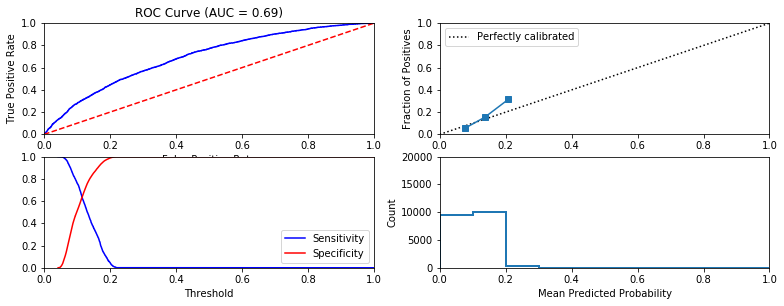


Similarity to LC grade ranking:  0.750032634634518
Brier score: 0.0938505502214099
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.89103333]


In [89]:
# cv_parameters = {'criterion':['entropy'],'max_depth':[10], 
#                  'max_features':['sqrt'], 'max_leaf_nodes':[None],
#                  'min_samples_leaf':[1], 
#                  'min_samples_split':[2],'min_weight_fraction_leaf':[0.0], 
#                  'n_estimators':[500] }
random_forest_original = fit_classification_original(model = YourModel,
                                                     data_dict = original_data_dict,
                                                     model_name = 'Original Your Model',
                                                     random_state=123,
                                                     cv_parameters = {})

## Test regression models

In [82]:
### Data Dictionary of 'just_your_features'
data_dict_facts = prepare_data(feature_subset = just_your_features, random_state=123)

In [58]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression
<font color=blue> Single train-test split

In [30]:
## First, trying l1 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': [0.00001,0.0001,0.001,0.1,1,10,100,1000] }

reg_lasso = fit_regression(model=linear_model.Lasso(),
                          data_dict=data_dict_facts,
                          cv_parameters=cv_parameters,
                          model_name='L1 Lasso Regression')

  Model: L1 Lasso Regression  Return column: ret_PESS
Fit time: 1.42 seconds
Optimal parameters:
{'alpha': 0.0001}

Testing r2 score: 0.017859312386694248
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -20.250443650690773
All test scores : [-0.04820262 -0.04713915 -0.0500861  -0.05668504 -0.05668504 -0.05668504
 -0.05668504 -0.05668504]
  Model: L1 Lasso Regression  Return column: ret_OPT
Fit time: 2.53 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.004667607675786556
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -33.07500965388176
All test scores : [-0.01089304 -0.00944911 -0.00933974 -0.01242886 -0.01242886 -0.01242886
 -0.01242886 -0.01242886]
  Model: L1 Lasso Regression  Return column: ret_INTa
Fit time: 2.3 seconds
Optimal parameters:
{'alpha': 0.0001}

Testing r2 score: 0.020832445193761484
Were parameters on edge (model) : False
Score variations around CV search grid (model) 

### $l_2$ regularized linear regressor
<font color='blue'> Single train-test split

In [31]:
## trying l2 regularized linear regression with hyper-parameters

cv_parameters = {'alpha':[0.00001,0.0001,0.001,0.1,1,10,100,1000, 10000]}

reg_ridge = fit_regression(model=linear_model.Ridge(),
                          data_dict=data_dict_facts,
                          cv_parameters=cv_parameters,
                          model_name='L2 Ridge Regression')

  Model: L2 Ridge Regression  Return column: ret_PESS
Fit time: 0.68 seconds
Optimal parameters:
{'alpha': 1000}

Testing r2 score: 0.016699216305566922
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -11.935892137839522
All test scores : [-0.04828991 -0.04828991 -0.04828986 -0.04828564 -0.04826542 -0.0481267
 -0.04716709 -0.04594859 -0.05143296]
  Model: L2 Ridge Regression  Return column: ret_OPT
Fit time: 0.66 seconds
Optimal parameters:
{'alpha': 1000}

Testing r2 score: 0.007586081935904598
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -26.574046172323722
All test scores : [-0.01110568 -0.01110568 -0.01110562 -0.01110092 -0.01107977 -0.01096205
 -0.01028689 -0.00877406 -0.00952031]
  Model: L2 Ridge Regression  Return column: ret_INTa
Fit time: 0.66 seconds
Optimal parameters:
{'alpha': 1000}

Testing r2 score: 0.01982386625967769
Were parameters on edge (model) : False
Score variations around CV s

### Multi-layer perceptron regressor
<font color='blue'> Single train-test split

In [32]:
## trying multi-layer perceptron regression with hyper-parameters

cv_parameters = {'hidden_layer_sizes': [(20,), (20,2), (20,10,2),(100,)],
                 'activation': ['tanh', 'relu', 'logistic'],
                 'solver': ['sgd'],
                 'alpha': [0.0001,0.001, 0.05],
                 'learning_rate': ['constant','adaptive'],
                }

reg_mlp = fit_regression(model=MLPRegressor(),
                        data_dict=data_dict_facts,
                        cv_parameters=cv_parameters,
                        model_name='MLPRegressor')

  Model: MLPRegressor  Return column: ret_PESS
Fit time: 492.45 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (20, 10, 2), 'learning_rate': 'adaptive', 'solver': 'sgd'}

Testing r2 score: -0.00043004130127832774
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -884.1233612034587
All test scores : [-0.28173012 -0.30619066 -0.3426181  -0.19465902 -0.24660617 -0.25906353
 -0.18646766 -0.10594193 -0.3144279  -0.25002196 -0.28457973 -0.25909887
 -0.22915953 -0.20634829 -0.17760231 -0.13788226 -0.26680932 -0.24017196
 -0.28422393 -0.21717561 -0.2584557  -0.20539283 -0.12396505 -0.13160483
 -0.42110012 -0.49107146 -0.21728822 -0.33038138 -0.20479961 -0.2074708
 -0.3612164  -0.30952993 -0.50345325 -0.55274168 -0.21469607 -0.27696429
 -0.06165235 -0.0715807  -0.42015142 -0.40526746 -0.53421019 -0.55518274
 -0.09094896 -0.19358084 -0.18477413 -0.10575959 -0.337277   -0.32637029
 -0.12161102 -0.1628539  -0.06101

### Random forest regressor
<font color='blue'> Single train-test split

In [59]:
## trying random forest regression with hyper-parameters

cv_parameters = { 'n_estimators': [100,150],
                    'max_features': ['auto'],
                    'max_depth' : [5, 10],
                    'criterion' :['mse']
                }
reg_rf = fit_regression(model=RandomForestRegressor(),
                       data_dict = data_dict_facts,
                       cv_parameters = cv_parameters,
                       model_name = 'Random Forest Regressor')

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 58.74 seconds
Optimal parameters:
{'criterion': 'mse', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}

Testing r2 score: 0.020423626196766742
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -14.452018846436937
All test scores : [-0.03972504 -0.04022946 -0.04546611 -0.04425439]
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 57.97 seconds
Optimal parameters:
{'criterion': 'mse', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100}

Testing r2 score: 0.014062382451981437
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -1781.123633527966
All test scores : [-0.00047438 -0.00066647 -0.0089236  -0.0067993 ]
  Model: Random Forest Regressor  Return column: ret_INTa
Fit time: 59.24 seconds
Optimal parameters:
{'criterion': 'mse', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 150}

Testing r2 score:

### When Separate Flag is True

### $l_1$ regularized linear regression
<font color='blue'> Separate Flag is true. <br> Single train-test split

In [21]:
## First, trying l1 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': [0.00001,0.0001,0.001,0.1,1,10,100,1000] }

reg_lasso_sep = fit_regression(model=linear_model.Lasso(),
                          data_dict=data_dict_facts,
                          cv_parameters=cv_parameters,
                          separate = True,
                          model_name='L1 Lasso Regression')

  Model: L1 Lasso Regression  Return column: ret_PESS
Fit time: 0.68 seconds
Optimal parameters:
model_0: {'alpha': 0.0001} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.020596234290635063
model_1: 0.07843830293627563
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : -19.394676026975244
All test scores : [-0.13866122 -0.13591488 -0.16227513 -0.1620763  -0.1620763  -0.1620763
 -0.1620763  -0.1620763 ]
Were parameters on edge (model_1) : False
Score variations around CV search grid (model_1) : -94.64721665248224
All test scores : [-0.08897165 -0.0855263  -0.0850787  -0.16560332 -0.16560332 -0.16560332
 -0.16560332 -0.16560332]
  Model: L1 Lasso Regression  Return column: ret_OPT
Fit time: 0.98 seconds
Optimal parameters:
model_0: {'alpha': 1e-05} model_1 {'alpha': 0.001}

Testing r2 scores:
model_0: 0.07653929295654893
model_1: 0.0774264269786421
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) 

### $l_2$ regularized linear regressor
<font color='blue'> Separate Flag is true. <br> Single train-test split

In [37]:
## trying l2 regularized linear regression with hyper-parameters

cv_parameters = {'alpha':[0.00001,0.0001,0.001,0.1,1,10,100,1000, 10000]}

reg_ridge_sep = fit_regression(model=linear_model.Ridge(),
                          data_dict=data_dict_facts,
                          cv_parameters=cv_parameters,
                          separate=True,
                          model_name='L2 Ridge Regression')

  Model: L2 Ridge Regression  Return column: ret_PESS
Fit time: 0.53 seconds
Optimal parameters:
model_0: {'alpha': 100} model_1 {'alpha': 100}

Testing r2 scores:
model_0: 0.022386822313586463
model_1: 0.08231147044199372
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : -12.94836239900649
All test scores : [-0.13977678 -0.13977676 -0.13977661 -0.13976077 -0.13964528 -0.13913526
 -0.13864963 -0.14615759 -0.15660249]
Were parameters on edge (model_1) : False
Score variations around CV search grid (model_1) : -82.53711261434434
All test scores : [-0.09030055 -0.0903004  -0.0902989  -0.0901429  -0.08918517 -0.08650916
 -0.08295093 -0.10301025 -0.15141623]
  Model: L2 Ridge Regression  Return column: ret_OPT
Fit time: 0.5 seconds
Optimal parameters:
model_0: {'alpha': 1} model_1 {'alpha': 100}

Testing r2 scores:
model_0: 0.07602151317266659
model_1: 0.08131278935828301
Were parameters on edge (model_0) : False
Score variations around CV search g

### Multi-layer perceptron regressor
<font color='blue'> Separate Flag is true. <br> Single train-test split

In [18]:
## trying multi-layer perceptron regression with hyper-parameters

cv_parameters = {'hidden_layer_sizes': [(20,), (20,2), (20,10,2),(100,)],
                 'activation': ['tanh', 'relu', 'logistic'],
                 'solver': ['sgd'],
                 'alpha': [0.001, 0.05, 0.1],
                 'learning_rate': ['constant','adaptive'],
                }

reg_mlp_sep = fit_regression(model=MLPRegressor(),
                        data_dict=data_dict_facts,
                        cv_parameters=cv_parameters,
                        separate=True,
                        model_name='MLPRegressor')

  Model: MLPRegressor  Return column: ret_PESS
Fit time: 506.7 seconds
Optimal parameters:
model_0: {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (20, 10, 2), 'learning_rate': 'constant', 'solver': 'sgd'} model_1 {'activation': 'logistic', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}

Testing r2 scores:
model_0: -0.0013690544543556449
model_1: -0.01968805650689842
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -2309.83251675206
All test scores : [-1.82742146 -1.61271831 -1.75140863 -1.87661223 -1.25997997 -1.00090621
 -0.8944075  -0.85707371 -1.63832097 -1.71591483 -1.58438448 -1.24119179
 -1.70352735 -1.17297937 -0.54665028 -0.70977521 -1.63032646 -1.35559407
 -2.1761689  -1.35065491 -1.3508466  -1.28076196 -0.55610152 -0.55425122
 -3.8906734  -3.69793104 -0.24232183 -2.03895013 -1.52880391 -0.89755537
 -2.01113915 -1.89765713 -2.76424611 -3.2269999  -0.31305665 -1.53345826
 -0

### Random forest regressor
<font color='blue'> Separate Flag is true <br> Single train-test split

In [60]:
## trying random forest regression with hyper-parameters

cv_parameters = { 'n_estimators': [100, 150],
                    'max_features': ['auto'],
                    'max_depth' : [5, 10, 20],
                    'criterion' :['mse']
                }
reg_rf_sep = fit_regression(model=RandomForestRegressor(),
                       data_dict = data_dict_facts,
                       cv_parameters = cv_parameters,
                       separate = True,
                       model_name = 'Random Forest Regressor')

  Model: Random Forest Regressor  Return column: ret_PESS
Fit time: 126.41 seconds
Optimal parameters:
model_0: {'criterion': 'mse', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 100} model_1 {'criterion': 'mse', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 150}

Testing r2 scores:
model_0: 0.0240180158441472
model_1: 0.08877765510267166
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : -101.61080345376827
All test scores : [-0.13610246 -0.13738321 -0.15829677 -0.15992095 -0.27439726 -0.26605206]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -83.08277203778086
All test scores : [-0.06551537 -0.0630616  -0.07620878 -0.07749163 -0.11545492 -0.11215781]
  Model: Random Forest Regressor  Return column: ret_OPT
Fit time: 124.18 seconds
Optimal parameters:
model_0: {'criterion': 'mse', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 150} model_1 {'criterion': 'mse', 'max_depth

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [212]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)9;*
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]
            
            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']
            
            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()
            
            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']
            
            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )
            
            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)
    
            ## Pick num_loans loans
            pf_test = data_test[:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()
            
            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

### Return strategies over 100 different train/test splits

#### Random Strategy
<font color='blue'> 100 train-test split average

In [64]:
ret_cols=['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

test_strategy = 'Random'

print('strategy:',test_strategy)   

strat_rand_100=[]

for i in range(100):
    data_dict_facts = prepare_data(feature_subset = just_your_features, random_state=np.random.randint(1000))
    predicted_return_lst = [reg_rf[ret_col]['model'].predict(data_dict_facts['X_test']) for ret_col in ret_cols]
    reg_rf_100 = reg_rf
    for i in range(4):
        predicted_return_ret_col = predicted_return_lst[i]
        reg_rf_100[ret_cols[i]]['predicted_return']=predicted_return_ret_col
    
    strat_rand_100.append(test_investments(data_dict_facts, regressor=reg_rf_100,strategy = test_strategy))
    

for ret_col in ret_cols:
    ret_col_return = np.mean([a[ret_col]['average return']  for a in strat_rand_100])
    print(ret_col + ': ' + str(ret_col_return))

strategy: Random
ret_PESS: 0.005499488914369655
ret_OPT: 0.04746817072184235
ret_INTa: 0.02283125277986482
ret_INTb: 0.059054158061239787


#### Default Based
<font color='blue'> 100 train-test splits

In [163]:
ret_cols=['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

test_strategy = 'Default-based'

print('strategy:',test_strategy)   

strat_rand_100=[]

for i in range(100):
    data_dict_facts = prepare_data(feature_subset = just_your_features, random_state=np.random.randint(1000))
    predicted_probs_lst = random_forest_100['model'].predict_proba(data_dict_facts['X_test'])[:,1]
    yourmodel_100 = random_forest_100
    predicted_return_col = predicted_probs_lst
    yourmodel_100['y_pred_probs']=predicted_return_col
    strat_rand_100.append(test_investments(data_dict_facts, classifier=yourmodel_100 ,strategy = test_strategy))
    
for ret_col in ret_cols:
    ret_col_return = np.mean([a[ret_col]['average return']  for a in strat_rand_100])
    print(ret_col + ': ' + str(ret_col_return))

strategy: Default-based
ret_PESS: 0.017008751523278975
ret_OPT: 0.04508565053985187
ret_INTa: 0.02508346919087071
ret_INTb: 0.05775523713888917


In [ ]:
predicted_probs_lst[1]

#### Return based
<font color='blue'> 100 train-test splits

In [221]:
ret_cols=['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

test_strategy = 'Return-based'

print('strategy:',test_strategy)   

strat_rand_100=[]

for i in range(100):
    data_dict_facts = prepare_data(feature_subset = just_your_features, random_state=np.random.randint(1000))
    predicted_return_lst = [reg_rf[ret_col]['model'].predict(data_dict_facts['X_test']) for ret_col in ret_cols]
    reg_rf_100 = reg_rf
    for i in range(4):
        predicted_return_ret_col = predicted_return_lst[i]
        reg_rf_100[ret_cols[i]]['predicted_return']=predicted_return_ret_col
    
    strat_rand_100.append(test_investments(data_dict_facts, regressor=reg_rf_100,strategy = test_strategy))
    

for ret_col in ret_cols:
    ret_col_return = np.mean([a[ret_col]['average return']  for a in strat_rand_100])
    print(ret_col + ': ' + str(ret_col_return))

strategy: Return-based
ret_PESS: 0.017280130567933667
ret_OPT: 0.05267894928484985
ret_INTa: 0.02656582114376806
ret_INTb: 0.058435657827230175


#### Default-Retrun Based
<font color='blue'> 100 train-test splits

In [225]:
ret_cols=['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']

test_strategy = 'Default-return-based'    
    
strat_rand_100=[]

for i in range(100):
    data_dict_facts = prepare_data(feature_subset = just_your_features, random_state=np.random.randint(1000))
    predicted_regular_ret_lst = [reg_rf_sep[ret_col]['model_0'].predict(data_dict_facts['X_test']) for ret_col in ret_cols]
    predicted_default_ret_lst = [reg_rf_sep[ret_col]['model_1'].predict(data_dict_facts['X_test']) for ret_col in ret_cols]
    reg_rf_sep_100 = reg_rf_sep
    predicted_probs_lst = random_forest_100['model'].predict_proba(data_dict_facts['X_test'])[:,1]
    yourmodel_100 = random_forest_100
    predicted_return_col = predicted_probs_lst
    yourmodel_100['y_pred_probs']=predicted_return_col
    
    for i in range(4):
        predicted_regular_ret_col = predicted_regular_ret_lst[i]
        predicted_default_ret_col = predicted_default_ret_lst[i]
        reg_rf_sep_100[ret_cols[i]]['predicted_regular_return'] = predicted_regular_ret_col
        reg_rf_sep_100[ret_cols[i]]['predicted_default_return'] = predicted_default_ret_col
    
    strat_rand_100.append(test_investments(data_dict_facts, regressor=reg_rf_sep_100, classifier= yourmodel_100, strategy = test_strategy))

for ret_col in ret_cols:
    ret_col_return = np.mean([a[ret_col]['average return']  for a in strat_rand_100])
    print(ret_col + ': ' + str(ret_col_return))

ret_PESS: 0.01632101820717608
ret_OPT: 0.04797651787128867
ret_INTa: 0.02560424307022996
ret_INTb: 0.060104417735756935


### Test investment startegies over single train/test split

#### Random Startegy
<font color='blue'> Single train-test split

In [137]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(data_dict_facts, regressor=reg_rf,strategy = test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: 0.010740012571262232
ret_OPT: 0.04615277950417514
ret_INTa: 0.029311118699071343
ret_INTb: 0.055976218067791454


#### Default-based
<font color='blue'> Single train-test split

In [169]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_def = test_investments(data_dict_facts, classifier=random_forest_100 ,strategy = test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

strategy: Default-based
ret_PESS: 0.017033046900171725
ret_OPT: 0.04507539486598489
ret_INTa: 0.025108336379962425
ret_INTb: 0.05774554238873617


#### Return-based
<font color='blue'> Single train-test split

In [139]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict_facts, regressor=reg_rf,strategy = test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.017280130567933667
ret_OPT: 0.05267894928484985
ret_INTa: 0.02656582114376806
ret_INTb: 0.058435657827230175


#### Default-return-based
<font color='blue'> Single train-test split

In [168]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
#cv_parameters = ...

#reg_separate = fit_regression(...)
reg_separate = reg_rf_sep

print('strategy:',test_strategy)
strat_defret = test_investments(data_dict_facts, regressor=reg_separate, classifier= random_forest_100 ,strategy = test_strategy)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

strategy: Default-return-based
ret_PESS: 0.017313845223558062
ret_OPT: 0.05042129702902571
ret_INTa: 0.020910190744461956
ret_INTb: 0.0568821410166027


## Sensitivity test of portfolio size

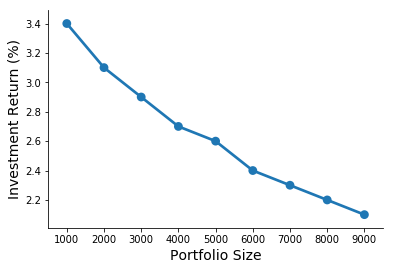

In [208]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):
  
    reg_0 = test_investments(data_dict_facts,classifier = random_forest,
                        regressor = reg_separate,strategy = 'Default-return-based', 
                        num_loans = num_loans,
                        random_state = default_seed,
                        output_to_file = False)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()